# Competition between lesions of septoria on a single leaf

This notebook details an exercice mimicking the competition between lesions of septoria on a wheat leaf. The graphical outputs can be used to evaluate the consistency of colonisation patterns on leaves.

_Authors: G. Garin (iTK) & C. Pradal (INRIA) - 03/12/2014_

In [1]:
import numpy as np
import pandas as pd
from pylab import *
from IPython.display import *
from alinea.alep.alep_color import cmap_competition

%matplotlib inline
rcParams['figure.figsize']=(8,8)
cmap, bounds, norm = cmap_competition()

Biological behavior assumed for competition
-------------------------------------------
* Lesions grow with a rectangular shape
* Lesions have a maximal size
* Assuming an optimal distribution and no competition, lesion growth is ultimately limited by leaf size
* Two lesions can not share the same leaf tissue
* Lesion growth stops at the frontier of contact with another lesion but continues on the rest of the periphery
* The maximal size of a lesion is reduced if it competes with others
  
Note : the impact of lesion status has not been tested in this example 

Algorithm
---------
* Step 1: Simulation of a leaf as a rectangle domain
* Step 2: Initialisation of the first lesions
* Simulation loop: For each time step:
    * Step 3: New lesions emerge at a predetermined pace
    * Step 4: Growth of each lesion 
    * Step 5: Spatialization of the lesions and competition between them
    * Step 6: Visualisation of the leaf status

### Step 1 : Simulation of a leaf as a square domain (image)

The leaf is represented as a simple rectangle with a fixed limited size.

* Model parameters: 
    * domain = length $L$, width $W$
    * size of a pixel = $dL$, $dW$ 

In [2]:
L, W = 10, 3
dL, dW = 0.01, 0.01
leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)

### Step 2 : Initialization of the first lesions

A lesion is represented as a growing rectangle colonizing pixels of leaf. There are two rates of expansion: rate in length > rate in width ($ratio = 4$)

* Lesion object: $lesion = {x, y, lid, dS, age, l, w}$
    - constant values: position = $(x, y)$ , identifier = $lid$, growth rate = $dS$
    - age of the lesion = $age$
    - length (resp. width) of the lesion =$(l, w)$


In [3]:
class Lesion(object):
    lid = 0
    ratio = 4.
    dS = 0.0006
    def __init__(self, x, y):
        self.age = 0
        self.x = x
        self.y = y
        self.w = 0.03/self.ratio
        self.l = self.ratio * self.w
        self.Smax = 0.3
        Lesion.lid += 1
        self.lid = Lesion.lid
        
    def reset(self):
        Lesion.lid=0
        
    def pixels(self, leaf):
        return leaf==self.lid
    
    def growth(self, dt):
        if self.surface <= self.Smax:
            self.dw = self.dS/(2*(self.ratio*self.l + self.w))
            self.dl = self.ratio*self.dw
            self.l += self.dl*dt
            self.w += self.dw*dt
            self.age += dt
    
    @property
    def surface(self):
        return self.l*self.w        

* Colonisation model: compute free space for each lesion to grow in its neighbourhood. Lesions are automatically sorted from older to younger. Priority is thus given to older lesions.

In [4]:
def colonisation(leaf, lesions):
    X, Y = leaf.shape  
    
    for lesion in lesions:
        lid = lesion.lid
        px, py = int(lesion.x*X), int(lesion.y*Y)
        pdx, pdy =  max(1,int(lesion.l/(2*dL))), max(1,int(lesion.w/(2*dW))) # inf part of the lesion
        slices = slice(max(0,px - pdx), min(px + pdx,X)), slice(max(0,py - pdy), min(Y,py + pdy))
        
        leaf[slices] = np.where(leaf[slices] == 0, lid, leaf[slices]) 
    
    return leaf

* Initialization/emergence model: new lesions emerge with a random distribution. New lesions can only emerge on a free space. Model parameters: 
  - Number of lesions = $n$

In [5]:
def init_lesion(leaf, n=10):
    X, Y = leaf.shape
    for i in range(n):
        x, y = np.random.random(2)
        px, py = int(x*X), int(y*Y)
        if leaf[x,y]==0:
            lesions.append(Lesion(x,y))
        
    leaf = colonisation(leaf, lesions)
    return leaf

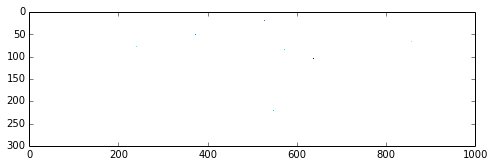

In [6]:
lesions = []
Lesion.lid = 0
leaf[:,:]=0
leaf = init_lesion(leaf)
imshow(leaf.T, cmap=cmap, interpolation='nearest')

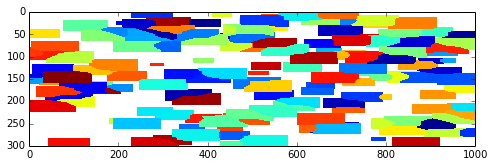

In [7]:
nb_steps = 3000
sev = []
for i in range(nb_steps):
    if i%200==0:
        leaf = init_lesion(leaf)
    for lesion in lesions:
        lesion.growth(dt=1.)
    sev.append(sum([(leaf==l.lid).sum()*0.01*0.01 for l in lesions])*100/(L*W))
    leaf = colonisation(leaf,lesions)
imshow(leaf.T, cmap=cmap, interpolation='nearest')

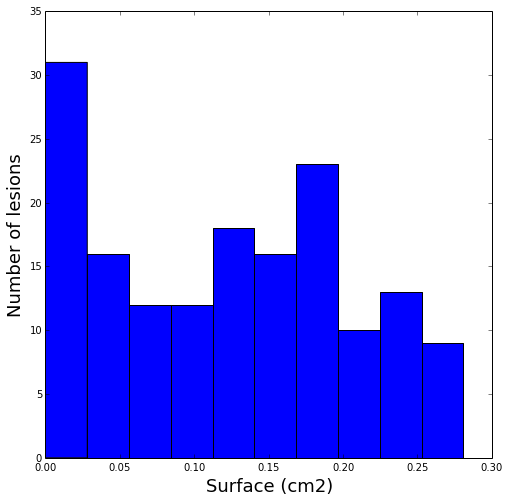

In [8]:
surfaces = [(leaf==l.lid).sum()*0.01*0.01 for l in lesions]
hist(surfaces)
xlabel('Surface (cm2)', fontsize=18)
ylabel('Number of lesions', fontsize=18)

Plot the leaf during the loop
------------------------------


In [9]:
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim, videofile=None):
    if not hasattr(anim, '_encoded_video'):
        if videofile:
            anim.save(videofile, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(videofile, "rb").read()
        else:
            with NamedTemporaryFile(suffix='.mp4') as f:
                anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
                video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

#from IPython.display import HTML

def display_animation(anim, videofile=None):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim, videofile))

In [10]:
fig = plt.figure()

lesions = []
Lesion.lid = 0
leaf[:,:]=0

leaf = init_lesion(leaf, 50)
# cmap, bounds, norm = cmap_competition(N=1500)
im = plt.imshow(leaf.T, cmap=cmap, norm=norm)
plt.colorbar(orientation='horizontal')

i = 1
nb_steps = 3000
def growth(*args):
    global i, leaf
    if i%200==0:
        leaf = init_lesion(leaf)
    for lesion in lesions:
        lesion.growth(dt=1.)
    leaf = colonisation(leaf,lesions)
    im.set_data(leaf.T)
    i+=1
    return im,
anim = animation.FuncAnimation(fig, growth, frames=nb_steps/3, interval=10, blit=True)
display_animation(anim, "lesions.mp4")

Test the model on a small leaf with two lesions
-----------------------------------------------
The lesion on the left is considered older and will have priority.

In [11]:
def two_lesions(x1, y1, x2, y2, nb_steps=1000):
    L, W = 2, 0.5
    dL, dW = 0.01, 0.01
    leaf = np.zeros((int(L/dL), int(W/dW)), dtype=int)
    X, Y = leaf.shape
    Lesion.lid = 0
    lesions = []
    lesions.append(Lesion(x1,y1))
    px1, py1 = int(x1*X), int(y1*Y)
    if leaf[px1,py1]==0:
        lesions.append(Lesion(x2,y2))
        
    for i in range(nb_steps):
        for lesion in lesions:
            lesion.growth(dt=1.)
        leaf = colonisation(leaf,lesions)
    return leaf

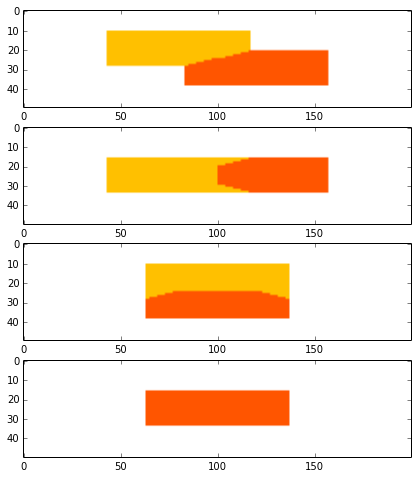

In [12]:
fig = plt.figure()
cmap, bounds, norm = cmap_competition()
im1 = fig.add_subplot(4,1,1)
leaf1 = two_lesions(x1=0.4, y1=0.4, x2=0.6, y2=0.6, nb_steps=1000)
im2 = fig.add_subplot(4,1,2)
leaf2 = two_lesions(x1=0.4, y1=0.5, x2=0.6, y2=0.5, nb_steps=1000)
im3 = fig.add_subplot(4,1,3)
leaf3 = two_lesions(x1=0.5, y1=0.4, x2=0.5, y2=0.6, nb_steps=1000)
im4 = fig.add_subplot(4,1,4)
leaf4 = two_lesions(x1=0.5, y1=0.5, x2=0.5, y2=0.5, nb_steps=1000)
im1.imshow(leaf1.T, cmap=cmap)
im2.imshow(leaf2.T, cmap=cmap)
im3.imshow(leaf3.T, cmap=cmap)
im4.imshow(leaf4.T, cmap=cmap)